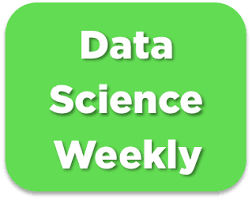

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE

from IPython.display import display

# Read file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


No missing values

In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


Outliers in age column. Let's drop it

In [6]:
data['age'].sort_values(ascending=False)

233196    123
11331     111
230590     79
268311     77
175251     73
         ... 
114803     17
151330     17
72137      17
151323     17
21340      17
Name: age, Length: 284580, dtype: int64

In [7]:
outlier_age = data['age'].mean() + data['age'].std()*3

data = data.loc[data['age']<outlier_age,:]

In [8]:
data.shape

(283563, 6)

In [9]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !

In order to get the same level of information in the created sample, we'll check countries propotions in initial dataset and keep them in data_sample.

In [10]:
fig = px.pie(data, names='country', title='Country proportions in dataset', hole=.3)
fig.show();

In [11]:
#Let's stratify our 10000 rows sample in the same propotions
US = data[data['country']=='US'].sample(5630, random_state=0)
China = data[data['country']=='China'].sample(2430, random_state=0)
UK = data[data['country']=='UK'].sample(1530, random_state=0)
Germany = data[data['country']=='Germany'].sample(410, random_state=0)

data_sample = pd.concat([US,China,UK,Germany])

In [12]:
data_sample.shape

(10000, 6)

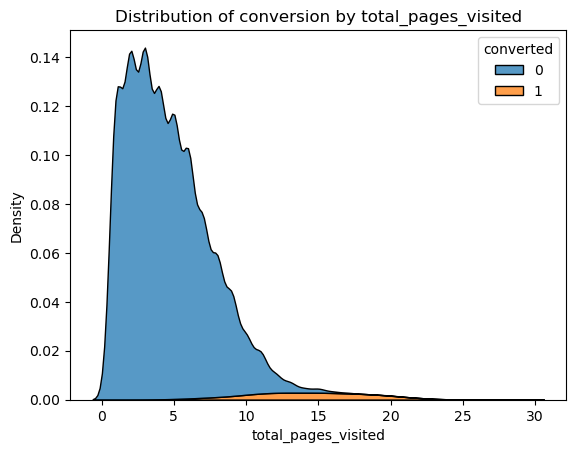

In [13]:
sns.kdeplot(data= data_sample, x='total_pages_visited', hue ='converted', multiple='stack')
plt.title('Distribution of conversion by total_pages_visited');

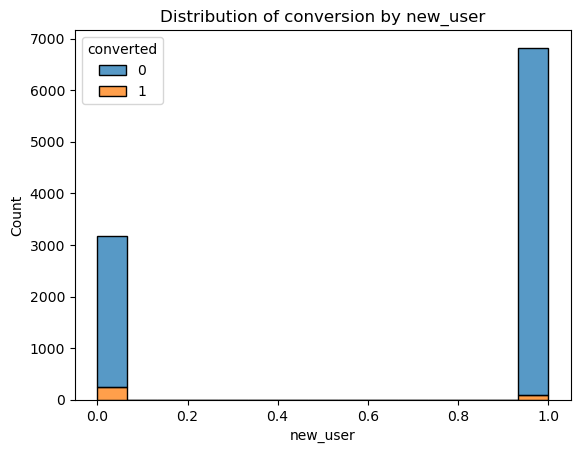

In [14]:
#New user distribution
sns.histplot(data= data_sample, x='new_user', hue ='converted',multiple='stack')
plt.title('Distribution of conversion by new_user');

In [15]:
#Overall age impact on converting
fig = px.line(data_sample.groupby('age')[['converted']].mean(),line_shape ='spline', markers=True,title='Conversion according to age',labels={'value':'conversion','variable':''})
display(fig)
#Age impact on converting by country
fig2 = px.box(data_sample, x='country', y='age', color='converted', title = 'Conversion by country according to age')
display(fig2)

In every country, younger people trend to convert quite more than the older ones

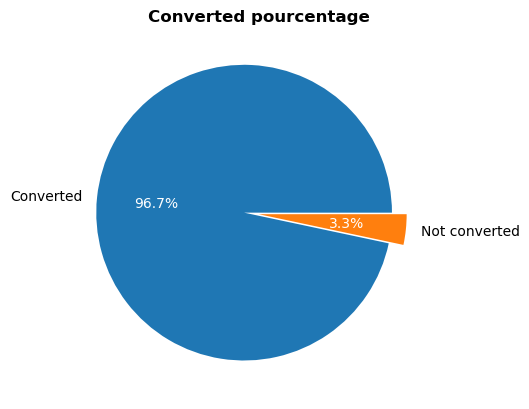

In [16]:
#Déclaration des valeurs/légendes utilisées dans le Pie chart
labels = 'Converted', 'Not converted'
sizes = data_sample['converted'].value_counts(normalize=True)
explode = (0.1, 0)

#Déclaration fonction ax.pie
fig, ax = plt.subplots()
patches, texts, autotexts =ax.pie(sizes, labels=labels, autopct='%1.1f%%', explode=explode)

#Boucle sur les éléments textes à passer en couleur blanc
for text in autotexts :
    text.set_color('white')
    
#Déclaration du titre et affichage du graphe
ax.set_title('Converted pourcentage',fontweight='bold')
plt.show()

The dataset is heavily imbalanced. Most of users don't convert 

In [17]:
data_sample['converted_YesNo']=data_sample['converted'].replace([0,1],['No','Yes'])

fig = px.sunburst(data_sample, path=['country','source', 'converted_YesNo'],
                  title='Conversion proportion by source by country',hover_name='converted',color_discrete_sequence=['dodgerblue','salmon','mediumpurple','mediumseagreen'])
fig.update_traces(textinfo="label+percent parent", insidetextorientation='horizontal')
fig.update_layout(
    width=700, 
    height=700)
fig.show()

In each country, SEO represents the main source.

In [18]:
fig = px.histogram(data_sample, x = 'country',color = 'converted_YesNo', 
                   title = 'Conversion per country',text_auto='.01f', barnorm ='percent', 
                   labels={'converted_YesNo':'Conversion'})
fig.show()

In Germany, there's more conversion in %, but Germany only represent 4% of the customers

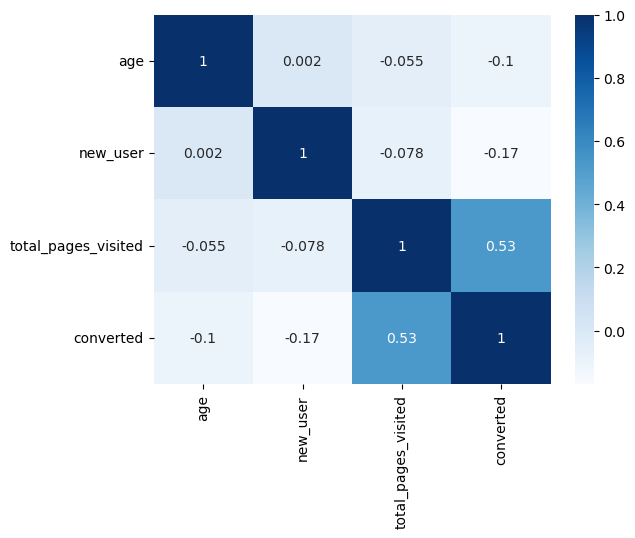

In [19]:
# Correlation matrix to detect correlated features
corr = data_sample.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='Blues');

There's a quite strong correlation between total_visited_pages and conversion. Let's check this out.

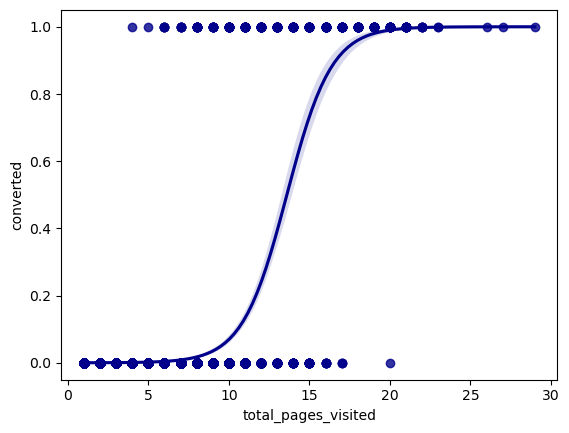

In [20]:
sns.regplot(data=data_sample, y='converted', x='total_pages_visited', logistic=True, color='darkblue');

Overall, there might be a relationship between number pages visited and conversion.
Is this the same for each country ? 

In [21]:
# Filtering data by country
data_china = data_sample.loc[data_sample['country']=='China',:]
data_UK = data_sample.loc[data_sample['country']=='UK',:]
data_Germany = data_sample.loc[data_sample['country']=='Germany',:]
data_US = data_sample.loc[data_sample['country']=='US',:]

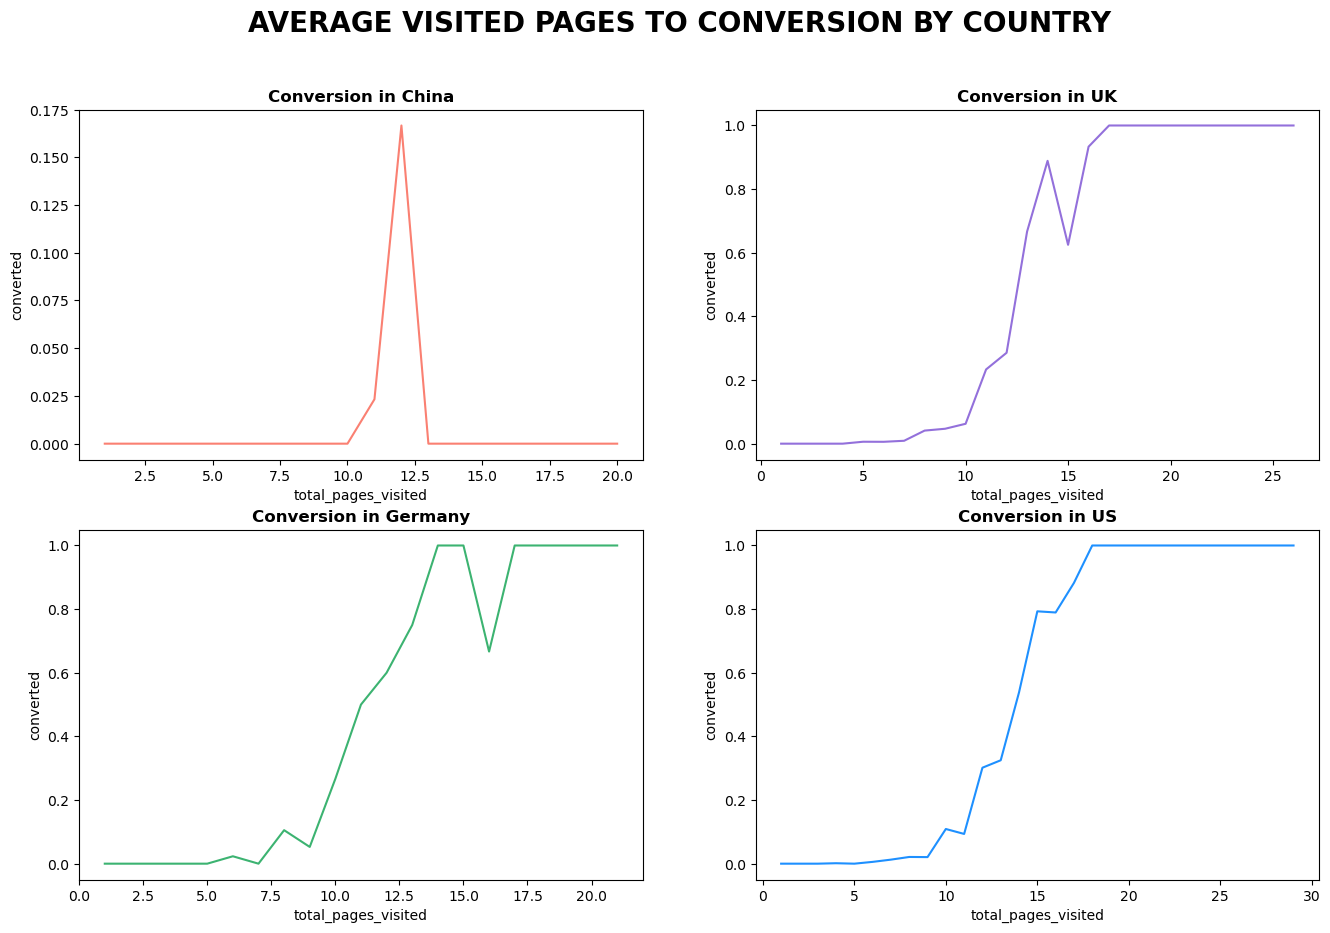

In [22]:
#Subplot conversion for each country
fig = plt.figure(figsize = (16,10))

plt.subplot(2, 2, 1)
sns.lineplot(data=data_china.groupby(['total_pages_visited'])['converted'].mean(), color='salmon')
plt.title('Conversion in China',fontweight='bold')
plt.subplot(2, 2, 2)
sns.lineplot(data=data_UK.groupby(['total_pages_visited'])['converted'].mean(),color='mediumpurple')
plt.title('Conversion in UK', fontweight='bold')
plt.subplot(2, 2, 3)
sns.lineplot(data=data_Germany.groupby(['total_pages_visited'])['converted'].mean(),color='mediumseagreen')
plt.title('Conversion in Germany',fontweight='bold')
plt.subplot(2, 2, 4)
sns.lineplot(data=data_US.groupby(['total_pages_visited'])['converted'].mean(), color='dodgerblue')
plt.title('Conversion in US',fontweight='bold')
plt.suptitle('AVERAGE VISITED PAGES TO CONVERSION BY COUNTRY', fontweight='bold', fontsize=20, color='black');

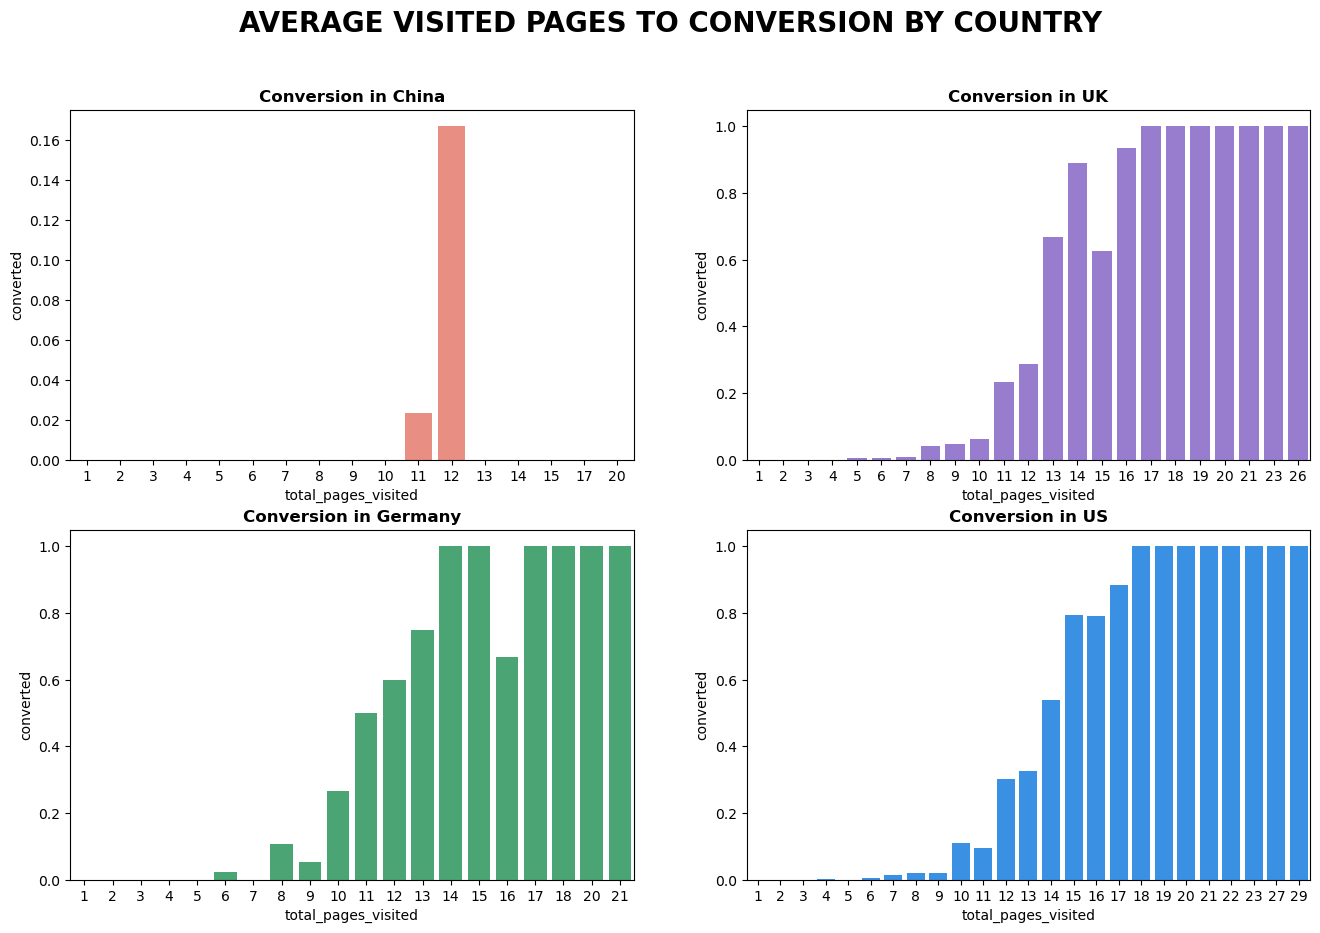

In [23]:
fig = plt.figure(figsize = (16,10))

plt.subplot(2, 2, 1)
sns.barplot(data=data_china, x='total_pages_visited', y='converted', color='salmon', errorbar=None)
plt.title('Conversion in China',fontweight='bold')
plt.subplot(2, 2, 2)
sns.barplot(data=data_UK, x='total_pages_visited', y='converted', color='mediumpurple',errorbar=None)
plt.title('Conversion in UK', fontweight='bold')
plt.subplot(2, 2, 3)
sns.barplot(data=data_Germany, x='total_pages_visited', y='converted', color='mediumseagreen',errorbar=None)
plt.title('Conversion in Germany',fontweight='bold')
plt.subplot(2, 2, 4)
sns.barplot(data=data_US, x='total_pages_visited', y='converted', color='dodgerblue',errorbar=None)
plt.title('Conversion in US',fontweight='bold')
plt.suptitle('AVERAGE VISITED PAGES TO CONVERSION BY COUNTRY', fontweight='bold', fontsize=20, color='black');

Obviously, the more pages visited the more conversion is likely to happen for each country. From around 10 pages visited, the conversion rate starts increasing in almost every country.**

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [24]:
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

In [25]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', list(X.columns))
print()

Explanatory variables :  ['country', 'age', 'new_user', 'source', 'total_pages_visited']



In [26]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [27]:
numeric_features = []
categorical_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']


In [28]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## **Testing models**

In [29]:
# Train model
classifier = LogisticRegression() 
classifier.fit(X_train, Y_train)

# Predictions on training and test sets
Y_train_logreg = classifier.predict(X_train)
Y_test_logreg = classifier.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_logreg))
print("f1-score on test set : ", f1_score(Y_test, Y_test_logreg))

f1-score on train set :  0.7658804912968126
f1-score on test set :  0.7543378995433789


In [30]:
# Train model
tree = DecisionTreeClassifier()
tree.fit(X_train,Y_train)

# Predictions on training and test sets
Y_train_tree = tree.predict(X_train)
Y_test_tree = tree.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_tree))
print("f1-score on test set : ", f1_score(Y_test, Y_test_tree))

f1-score on train set :  0.8020459577066952
f1-score on test set :  0.717074682367524


In [31]:
# Train model
randomforest = RandomForestClassifier()
randomforest.fit(X_train,Y_train)

# Predictions on training and test sets
Y_train_rf = randomforest.predict(X_train)
Y_test_rf = randomforest.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_rf))
print("f1-score on test set : ", f1_score(Y_test, Y_test_rf))

f1-score on train set :  0.8057823384016178
f1-score on test set :  0.7281553398058254


In [32]:
# Train model
kneighbors=KNeighborsClassifier()
kneighbors.fit(X_train,Y_train)

# Predictions on training and test sets
Y_train_kn = kneighbors.predict(X_train)
Y_test_kn = kneighbors.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_kn))
print("f1-score on test set : ", f1_score(Y_test, Y_test_kn))

f1-score on train set :  0.7803822036428784
f1-score on test set :  0.7349505840071877


In [33]:
# Train model
xgb = XGBClassifier()
xgb.fit(X_train,Y_train)

# Predictions on training and test sets
Y_train_xgb = xgb.predict(X_train)
Y_test_xgb = xgb.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_xgb))
print("f1-score on test set : ", f1_score(Y_test, Y_test_xgb))

f1-score on train set :  0.7771111444427778
f1-score on test set :  0.7549108491991539


In [34]:
voting = VotingClassifier(estimators=[
         ('logreg', classifier), ('xgb', xgb), ('tree',tree),('kneighbors',kneighbors),('randomforest',randomforest)],voting='soft',verbose=True)
voting = voting.fit(X_train, Y_train)
Y_train_pred = voting.predict(X_train)
Y_test_pred = voting.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

[Voting] ................... (1 of 5) Processing logreg, total=   0.4s
[Voting] ...................... (2 of 5) Processing xgb, total=   0.5s
[Voting] ..................... (3 of 5) Processing tree, total=   0.3s
[Voting] ............... (4 of 5) Processing kneighbors, total=   0.4s
[Voting] ............. (5 of 5) Processing randomforest, total=   7.8s
f1-score on train set :  0.7961515333734216
f1-score on test set :  0.7460606060606062


XGB and Logistic Regression seem to be the best models. We'll keep both and try to improve their results by GridSearch

## GridSearch and Performance assessment
**Grisdsearch**

In [35]:
# parameters
logreg = LogisticRegression()
params = {
    'solver': ['saga', 'lbfgs','sag'],
    'penalty':['l2'],
    'C' : [1000, 100, 10, 1, 0.1]
}
#grid search
gridsearch = GridSearchCV(logreg, param_grid=params, cv=5,scoring='f1')
gridsearch.fit(X_train, Y_train)
#Print the best parameters
print("Best parameters :",  gridsearch.best_params_)

Best parameters : {'C': 1, 'penalty': 'l2', 'solver': 'saga'}


In [36]:
# Train model
classifier = LogisticRegression(C=1, solver='saga', penalty='l2') 
classifier.fit(X_train, Y_train)

# Predictions on training and test sets
Y_train_logreg = classifier.predict(X_train)
Y_test_logreg = classifier.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_logreg))
print("f1-score on test set : ", f1_score(Y_test, Y_test_logreg))

f1-score on train set :  0.7658804912968126
f1-score on test set :  0.7543378995433789


In [37]:
# parameters
xgb = XGBClassifier()
params = {
        'min_child_weight': [2,4,6,8],
        'n_estimators': [10,50,100],
        'gamma': [0, 0.5, 1, 1.5,2],
        'max_depth': [4,6,8,10],
        
}
#grid search
gridsearch = GridSearchCV(xgb, param_grid=params, cv=5,scoring='f1')
gridsearch.fit(X_train, Y_train)

#Print the best parameters
print("Best parameters :",  gridsearch.best_params_)

Best parameters : {'gamma': 2, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 50}


In [49]:
# Train model
xgb = XGBClassifier(max_depth= 4, n_estimators = 50, min_child_weight= 4,gamma=2)
xgb.fit(X_train, Y_train)

# Predictions on training and test sets
Y_train_xgb = xgb.predict(X_train)
Y_test_xgb = xgb.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_xgb))
print("f1-score on test set : ", f1_score(Y_test, Y_test_xgb))

f1-score on train set :  0.768472906403941
f1-score on test set :  0.7555019596020501


GridSearch lead to no significant improvement

**Confusion matrix**

Confusion matrix on train set : 


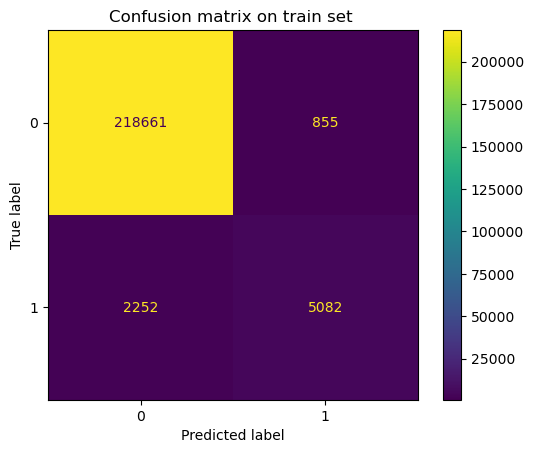

f1-score on train set :  0.7658804912968126

Confusion matrix on test set : 


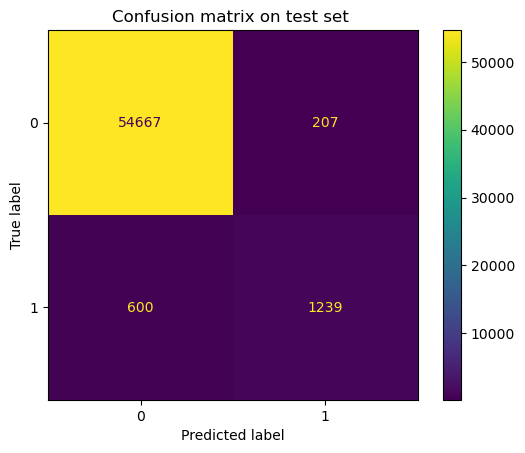

f1-score on test set :  0.7543378995433789


In [39]:
#Confusion matrix for LogisticRegression

print("Confusion matrix on train set : ")
cm = confusion_matrix(Y_train, Y_train_logreg, labels=classifier.classes_)
cm_display = ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_logreg)
cm_display.ax_.set_title("Confusion matrix on train set ") # Simply to set a title
plt.show() # Show graph
print("f1-score on train set : ", f1_score(Y_train, Y_train_logreg))
print()
print("Confusion matrix on test set : ")
cm = confusion_matrix(Y_test, Y_test_logreg, labels=classifier.classes_)
cm_display = ConfusionMatrixDisplay.from_predictions(Y_test, Y_test_logreg)
cm_display.ax_.set_title("Confusion matrix on test set ") # Simply to set a title
plt.show() # Show graph
print("f1-score on test set : ", f1_score(Y_test, Y_test_logreg))

Confusion matrix on train set : 


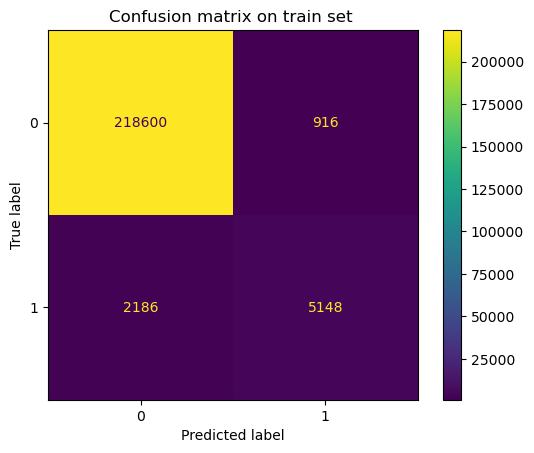

f1-score on train set :  0.768472906403941

Confusion matrix on test set : 


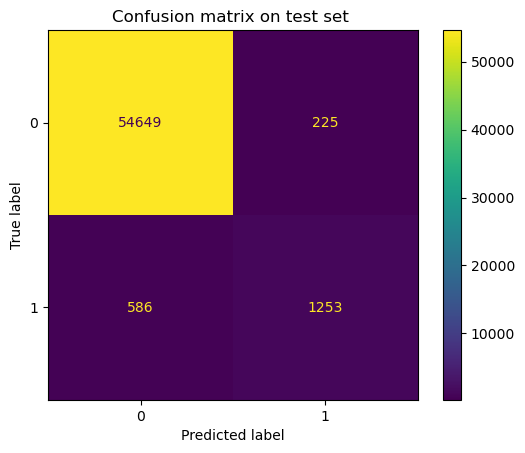

f1-score on test set :  0.7555019596020501


In [50]:
#Confusion matrix for XGB

print("Confusion matrix on train set : ")
cm = confusion_matrix(Y_train, Y_train_xgb, labels=xgb.classes_)
cm_display = ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_xgb)
cm_display.ax_.set_title("Confusion matrix on train set ") # Simply to set a title
plt.show() # Show graph
print("f1-score on train set : ", f1_score(Y_train, Y_train_xgb))
print()
print("Confusion matrix on test set : ")
cm = confusion_matrix(Y_test, Y_test_xgb, labels=xgb.classes_)
cm_display = ConfusionMatrixDisplay.from_predictions(Y_test, Y_test_xgb)
cm_display.ax_.set_title("Confusion matrix on test set ") # Simply to set a title
plt.show() # Show graph
print("f1-score on test set : ", f1_score(Y_test, Y_test_xgb))

## Features importance

In [41]:
liste_feature = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())
coef = classifier.coef_[0].squeeze()# CAREFUL HERE. We need to access first index of our list because 
                                            # Data needs to be 1 dimensional
                                            # That's what .squeeze() is for
feature_importance = pd.DataFrame({"features":liste_feature, "coefficients":coef})
display(feature_importance.sort_values(by='coefficients', ascending=False))

,features,coefficients
3,country_Germany,3.588062
4,country_UK,3.475841
5,country_US,3.114288
2,total_pages_visited,2.547370
7,source_Seo,-0.024313
6,source_Direct,-0.210850
0,age,-0.605403
1,new_user,-0.797859


In [42]:
# Compute abs()
feature_importance['coefficients']= feature_importance['coefficients'].abs()
# Visualize ranked features
fig = px.bar(x="features", 
            y="coefficients", 
            data_frame=feature_importance.sort_values(by="coefficients", ascending=False), 
            color='features', title='Feature importances')
fig.update_layout(showlegend=False)

Country is very important feature. Indeed, total_pages_visited is only ranked 4th.

In [51]:
coef = xgb.feature_importances_
xgb_feature_importance = pd.DataFrame({"features":liste_feature, "coefficients":coef})
display(xgb_feature_importance.sort_values(by='coefficients', ascending=False))

,features,coefficients
2,total_pages_visited,0.662148
3,country_Germany,0.082587
4,country_UK,0.078726
1,new_user,0.077117
5,country_US,0.059301
0,age,0.029228
6,source_Direct,0.007898
7,source_Seo,0.002995


In [52]:
# Visualize ranked features
fig = px.bar(x="features", 
            y="coefficients", 
            data_frame=xgb_feature_importance.sort_values(by="coefficients", ascending=False), 
            color='features', title='Feature importances')
fig.update_layout(showlegend=False)

Both models gave similar results but for Logistic Regression country is the main feature importance whereas for XGB model total_pages_visited is the key criterion far ahead of the others

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

We'll go ahead with LogisticRegression model

In [45]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

LogisticRegression(C=1, solver='saga')

In [46]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

Prediction set (without labels) : (31620, 5)


In [47]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.30507698 -1.47587081  3.32514532  0.          1.          0.
   0.          1.        ]
 [-1.04496163  0.67756608  0.0365738   0.          1.          0.
   1.          0.        ]
 [ 0.18817945  0.67756608 -1.15927039  0.          0.          0.
   0.          1.        ]
 [ 0.18817945  0.67756608  0.33553485  0.          0.          1.
   0.          0.        ]
 [-0.67501931 -1.47587081 -0.56134829  0.          0.          0.
   0.          1.        ]]


In [48]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_JEREMY-LogReg.csv', index=False)


## Analyzing the coefficients and interpreting the result


All models that have been tested gave quite good results and can decently generalize.


**Analysis about data :**  
    Age is a major stake. Older people don't convert.  
    Targetting new users doesn't seem to be relevant given they tend to convert quite less than old users. Should strive to keep these users rather than seeking new ones.
    The more time spent (total_pages_visited) the more conversion we get.  
    German people get the highest conversion rate among all other countries. Maybe target this population could be relevant ?   
    
**Analysis about model** :  
    Some models and hyperparameters were ignored due to a huge time to run them.  
    Trying some other hyperparameters could improve the results.  
    We should focus on recall and try to improve it because that's the main type of error the model made.